In [1]:
!pip install sentence-transformers
!pip install pandas


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch
import random

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [3]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [4]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [5]:
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score,bin_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0,0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0,0


In [6]:
data = data.dropna()

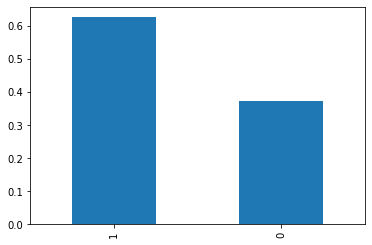

In [7]:
data['bin_score'].value_counts(normalize=True).plot(kind='bar');

In [8]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [9]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.2)

In [10]:
len(train_data)*0.5, type(train_labels), train_labels.shape


(1604.0, numpy.ndarray, (3208,))

In [11]:
train_data = train_data.iloc[0:1604]
train_labels = train_labels[0:1604]

In [12]:
type(train_data), type(train_labels), len(train_data), len(train_labels)

(pandas.core.frame.DataFrame, numpy.ndarray, 1604, 1604)

In [13]:

def random_deletion(sentence, p=0.2): 
  words = sentence.split()
  if len(words) <= 3:
    return ' '.join(words)
  remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
  if len(remaining) == 0: # if not left, sample a random word
    return ' '.join([random.choice(words)])
  else:
    return ' '.join(remaining)


In [14]:
random_deletion("Hi i am ")

'Hi i am'

In [15]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs, datatype='train'):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)
  i=0

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))
    
    if datatype=='train' and random.random() >= 0.5:
      sAns = random_deletion(sentence2[idxA])
      #print(sAns)
      pairs.append(InputExample(texts=[dAns, sAns], label=label))
      i = i+1
  
  print("No.of augmented examples : ", i)

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [16]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [17]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples, datatype='test')

No.of augmented examples :  0


In [18]:
len(test_examples)

802

In [19]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

No.of augmented examples :  852


In [20]:
len(train_examples)

2456

In [21]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v4_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [22]:
from sentence_transformers import evaluation
import math


def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
  #test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
  x_test_dA = test_data['ReferenceAnswer'].values.tolist()
  x_test_sA = test_data['StudentAnswer'].values.tolist()
  y_test = test_labels 

  evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

In [57]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 19:38:21 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-09-07 19:38:22 - Use pytorch device: cuda
2022-09-07 19:38:22 - Softmax loss: #Vectors concatenated: 3
154


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:38:34 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 19:38:35 - Accuracy with Cosine-Similarity:           77.68	(Threshold: 0.4959)
2022-09-07 19:38:35 - F1 with Cosine-Similarity:                 83.32	(Threshold: 0.3624)
2022-09-07 19:38:35 - Precision with Cosine-Similarity:          73.70
2022-09-07 19:38:35 - Recall with Cosine-Similarity:             95.83
2022-09-07 19:38:35 - Average Precision with Cosine-Similarity:  89.70

2022-09-07 19:38:35 - Accuracy with Manhattan-Distance:           77.31	(Threshold: 338.3260)
2022-09-07 19:38:35 - F1 with Manhattan-Distance:                 83.42	(Threshold: 385.9946)
2022-09-07 19:38:35 - Precision with Manhattan-Distance:          73.74
2022-09-07 19:38:35 - Recall with Manhattan-Distance:             96.02
2022-09-07 19:38:35 - Average Precision with Manhattan-Distance:  89.82

2022-09-07 19:38:35 - Accuracy with Euclidean-Distance:           77.56	(Threshold: 15.4615)
2022-09-07 19:38:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:38:48 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 19:38:48 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.4148)
2022-09-07 19:38:48 - F1 with Cosine-Similarity:                 85.38	(Threshold: 0.2960)
2022-09-07 19:38:48 - Precision with Cosine-Similarity:          77.38
2022-09-07 19:38:48 - Recall with Cosine-Similarity:             95.23
2022-09-07 19:38:48 - Average Precision with Cosine-Similarity:  90.71

2022-09-07 19:38:48 - Accuracy with Manhattan-Distance:           80.80	(Threshold: 373.5344)
2022-09-07 19:38:48 - F1 with Manhattan-Distance:                 85.56	(Threshold: 401.1766)
2022-09-07 19:38:48 - Precision with Manhattan-Distance:          78.76
2022-09-07 19:38:48 - Recall with Manhattan-Distance:             93.64
2022-09-07 19:38:48 - Average Precision with Manhattan-Distance:  90.82

2022-09-07 19:38:48 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 17.1215)
2022-09-07 19:38:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:39:01 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 19:39:02 - Accuracy with Cosine-Similarity:           80.55	(Threshold: 0.2660)
2022-09-07 19:39:02 - F1 with Cosine-Similarity:                 85.77	(Threshold: 0.2660)
2022-09-07 19:39:02 - Precision with Cosine-Similarity:          79.26
2022-09-07 19:39:02 - Recall with Cosine-Similarity:             93.44
2022-09-07 19:39:02 - Average Precision with Cosine-Similarity:  90.53

2022-09-07 19:39:02 - Accuracy with Manhattan-Distance:           79.68	(Threshold: 420.0049)
2022-09-07 19:39:02 - F1 with Manhattan-Distance:                 85.56	(Threshold: 445.2050)
2022-09-07 19:39:02 - Precision with Manhattan-Distance:          76.41
2022-09-07 19:39:02 - Recall with Manhattan-Distance:             97.22
2022-09-07 19:39:02 - Average Precision with Manhattan-Distance:  90.62

2022-09-07 19:39:02 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 19.1368)
2022-09-07 19:39:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:39:14 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 19:39:14 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.2892)
2022-09-07 19:39:14 - F1 with Cosine-Similarity:                 86.00	(Threshold: 0.1721)
2022-09-07 19:39:14 - Precision with Cosine-Similarity:          78.81
2022-09-07 19:39:14 - Recall with Cosine-Similarity:             94.63
2022-09-07 19:39:14 - Average Precision with Cosine-Similarity:  91.00

2022-09-07 19:39:14 - Accuracy with Manhattan-Distance:           80.92	(Threshold: 436.1743)
2022-09-07 19:39:14 - F1 with Manhattan-Distance:                 86.12	(Threshold: 460.7914)
2022-09-07 19:39:14 - Precision with Manhattan-Distance:          77.94
2022-09-07 19:39:14 - Recall with Manhattan-Distance:             96.22
2022-09-07 19:39:14 - Average Precision with Manhattan-Distance:  91.13

2022-09-07 19:39:14 - Accuracy with Euclidean-Distance:           81.17	(Threshold: 20.6629)
2022-09-07 19:39:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:39:27 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 19:39:28 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.1812)
2022-09-07 19:39:28 - F1 with Cosine-Similarity:                 85.48	(Threshold: 0.1130)
2022-09-07 19:39:28 - Precision with Cosine-Similarity:          78.63
2022-09-07 19:39:28 - Recall with Cosine-Similarity:             93.64
2022-09-07 19:39:28 - Average Precision with Cosine-Similarity:  90.94

2022-09-07 19:39:28 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 429.2671)
2022-09-07 19:39:28 - F1 with Manhattan-Distance:                 85.22	(Threshold: 466.4043)
2022-09-07 19:39:28 - Precision with Manhattan-Distance:          79.18
2022-09-07 19:39:28 - Recall with Manhattan-Distance:             92.25
2022-09-07 19:39:28 - Average Precision with Manhattan-Distance:  91.04

2022-09-07 19:39:28 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 18.9730)
2022-09-07 19:39:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:39:40 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 19:39:41 - Accuracy with Cosine-Similarity:           80.05	(Threshold: 0.2277)
2022-09-07 19:39:41 - F1 with Cosine-Similarity:                 85.59	(Threshold: 0.0913)
2022-09-07 19:39:41 - Precision with Cosine-Similarity:          77.85
2022-09-07 19:39:41 - Recall with Cosine-Similarity:             95.03
2022-09-07 19:39:41 - Average Precision with Cosine-Similarity:  90.70

2022-09-07 19:39:41 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 443.8375)
2022-09-07 19:39:41 - F1 with Manhattan-Distance:                 85.79	(Threshold: 467.0510)
2022-09-07 19:39:41 - Precision with Manhattan-Distance:          78.74
2022-09-07 19:39:41 - Recall with Manhattan-Distance:             94.23
2022-09-07 19:39:41 - Average Precision with Manhattan-Distance:  90.82

2022-09-07 19:39:41 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 20.1788)
2022-09-07 19:39:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:39:53 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 19:39:53 - Accuracy with Cosine-Similarity:           80.17	(Threshold: 0.4821)
2022-09-07 19:39:53 - F1 with Cosine-Similarity:                 85.27	(Threshold: 0.3790)
2022-09-07 19:39:53 - Precision with Cosine-Similarity:          79.42
2022-09-07 19:39:53 - Recall with Cosine-Similarity:             92.05
2022-09-07 19:39:53 - Average Precision with Cosine-Similarity:  90.52

2022-09-07 19:39:53 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 400.1886)
2022-09-07 19:39:53 - F1 with Manhattan-Distance:                 85.12	(Threshold: 433.3365)
2022-09-07 19:39:53 - Precision with Manhattan-Distance:          77.89
2022-09-07 19:39:53 - Recall with Manhattan-Distance:             93.84
2022-09-07 19:39:53 - Average Precision with Manhattan-Distance:  90.62

2022-09-07 19:39:53 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 18.3246)
2022-09-07 19:39:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:40:05 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 19:40:06 - Accuracy with Cosine-Similarity:           79.80	(Threshold: 0.1110)
2022-09-07 19:40:06 - F1 with Cosine-Similarity:                 85.16	(Threshold: 0.1046)
2022-09-07 19:40:06 - Precision with Cosine-Similarity:          78.95
2022-09-07 19:40:06 - Recall with Cosine-Similarity:             92.45
2022-09-07 19:40:06 - Average Precision with Cosine-Similarity:  90.46

2022-09-07 19:40:06 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 480.1751)
2022-09-07 19:40:06 - F1 with Manhattan-Distance:                 85.43	(Threshold: 489.0123)
2022-09-07 19:40:06 - Precision with Manhattan-Distance:          78.82
2022-09-07 19:40:06 - Recall with Manhattan-Distance:             93.24
2022-09-07 19:40:06 - Average Precision with Manhattan-Distance:  90.56

2022-09-07 19:40:06 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 21.2808)
2022-09-07 19:40:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:40:18 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 19:40:19 - Accuracy with Cosine-Similarity:           79.80	(Threshold: 0.2270)
2022-09-07 19:40:19 - F1 with Cosine-Similarity:                 85.20	(Threshold: 0.0596)
2022-09-07 19:40:19 - Precision with Cosine-Similarity:          77.61
2022-09-07 19:40:19 - Recall with Cosine-Similarity:             94.43
2022-09-07 19:40:19 - Average Precision with Cosine-Similarity:  90.41

2022-09-07 19:40:19 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 457.9717)
2022-09-07 19:40:19 - F1 with Manhattan-Distance:                 85.43	(Threshold: 457.9717)
2022-09-07 19:40:19 - Precision with Manhattan-Distance:          79.25
2022-09-07 19:40:19 - Recall with Manhattan-Distance:             92.64
2022-09-07 19:40:19 - Average Precision with Manhattan-Distance:  90.51

2022-09-07 19:40:19 - Accuracy with Euclidean-Distance:           80.17	(Threshold: 20.8122)
2022-09-07 19:40:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:40:31 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 19:40:31 - Accuracy with Cosine-Similarity:           79.93	(Threshold: 0.2009)
2022-09-07 19:40:31 - F1 with Cosine-Similarity:                 85.23	(Threshold: 0.0841)
2022-09-07 19:40:31 - Precision with Cosine-Similarity:          77.92
2022-09-07 19:40:31 - Recall with Cosine-Similarity:             94.04
2022-09-07 19:40:31 - Average Precision with Cosine-Similarity:  90.46

2022-09-07 19:40:31 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 460.4834)
2022-09-07 19:40:31 - F1 with Manhattan-Distance:                 85.43	(Threshold: 471.7573)
2022-09-07 19:40:31 - Precision with Manhattan-Distance:          78.82
2022-09-07 19:40:31 - Recall with Manhattan-Distance:             93.24
2022-09-07 19:40:31 - Average Precision with Manhattan-Distance:  90.56

2022-09-07 19:40:31 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 21.7734)
2022-09-07 19:40:

0.9113187971150507

In [58]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 19:40:34 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-09-07 19:40:34 - Use pytorch device: cuda
2022-09-07 19:40:34 - Softmax loss: #Vectors concatenated: 3
154


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:40:45 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 19:40:46 - Accuracy with Cosine-Similarity:           75.44	(Threshold: 0.5219)
2022-09-07 19:40:46 - F1 with Cosine-Similarity:                 81.40	(Threshold: 0.4040)
2022-09-07 19:40:46 - Precision with Cosine-Similarity:          73.98
2022-09-07 19:40:46 - Recall with Cosine-Similarity:             90.46
2022-09-07 19:40:46 - Average Precision with Cosine-Similarity:  87.49

2022-09-07 19:40:46 - Accuracy with Manhattan-Distance:           75.44	(Threshold: 530.0317)
2022-09-07 19:40:46 - F1 with Manhattan-Distance:                 81.94	(Threshold: 530.0317)
2022-09-07 19:40:46 - Precision with Manhattan-Distance:          76.02
2022-09-07 19:40:46 - Recall with Manhattan-Distance:             88.87
2022-09-07 19:40:46 - Average Precision with Manhattan-Distance:  86.91

2022-09-07 19:40:46 - Accuracy with Euclidean-Distance:           75.69	(Threshold: 24.2193)
2022-09-07 19:40:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:40:58 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 19:40:58 - Accuracy with Cosine-Similarity:           78.18	(Threshold: 0.4363)
2022-09-07 19:40:58 - F1 with Cosine-Similarity:                 83.32	(Threshold: 0.4363)
2022-09-07 19:40:58 - Precision with Cosine-Similarity:          80.04
2022-09-07 19:40:58 - Recall with Cosine-Similarity:             86.88
2022-09-07 19:40:58 - Average Precision with Cosine-Similarity:  88.53

2022-09-07 19:40:58 - Accuracy with Manhattan-Distance:           78.05	(Threshold: 593.5033)
2022-09-07 19:40:58 - F1 with Manhattan-Distance:                 83.88	(Threshold: 643.4340)
2022-09-07 19:40:58 - Precision with Manhattan-Distance:          75.32
2022-09-07 19:40:58 - Recall with Manhattan-Distance:             94.63
2022-09-07 19:40:58 - Average Precision with Manhattan-Distance:  88.54

2022-09-07 19:40:58 - Accuracy with Euclidean-Distance:           78.30	(Threshold: 27.0821)
2022-09-07 19:40:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:41:10 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 19:41:10 - Accuracy with Cosine-Similarity:           78.43	(Threshold: 0.4097)
2022-09-07 19:41:10 - F1 with Cosine-Similarity:                 83.86	(Threshold: 0.2990)
2022-09-07 19:41:10 - Precision with Cosine-Similarity:          76.73
2022-09-07 19:41:10 - Recall with Cosine-Similarity:             92.45
2022-09-07 19:41:10 - Average Precision with Cosine-Similarity:  89.58

2022-09-07 19:41:10 - Accuracy with Manhattan-Distance:           78.30	(Threshold: 667.0123)
2022-09-07 19:41:10 - F1 with Manhattan-Distance:                 84.03	(Threshold: 713.6180)
2022-09-07 19:41:10 - Precision with Manhattan-Distance:          74.58
2022-09-07 19:41:10 - Recall with Manhattan-Distance:             96.22
2022-09-07 19:41:10 - Average Precision with Manhattan-Distance:  89.61

2022-09-07 19:41:10 - Accuracy with Euclidean-Distance:           78.18	(Threshold: 29.4422)
2022-09-07 19:41:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:41:22 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 19:41:22 - Accuracy with Cosine-Similarity:           79.43	(Threshold: 0.3310)
2022-09-07 19:41:22 - F1 with Cosine-Similarity:                 85.04	(Threshold: 0.3069)
2022-09-07 19:41:22 - Precision with Cosine-Similarity:          78.17
2022-09-07 19:41:22 - Recall with Cosine-Similarity:             93.24
2022-09-07 19:41:22 - Average Precision with Cosine-Similarity:  89.57

2022-09-07 19:41:22 - Accuracy with Manhattan-Distance:           79.43	(Threshold: 711.5414)
2022-09-07 19:41:22 - F1 with Manhattan-Distance:                 85.31	(Threshold: 764.6950)
2022-09-07 19:41:22 - Precision with Manhattan-Distance:          76.50
2022-09-07 19:41:22 - Recall with Manhattan-Distance:             96.42
2022-09-07 19:41:22 - Average Precision with Manhattan-Distance:  89.67

2022-09-07 19:41:22 - Accuracy with Euclidean-Distance:           79.43	(Threshold: 32.8981)
2022-09-07 19:41:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:41:34 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 19:41:34 - Accuracy with Cosine-Similarity:           79.80	(Threshold: 0.3412)
2022-09-07 19:41:34 - F1 with Cosine-Similarity:                 85.02	(Threshold: 0.2240)
2022-09-07 19:41:34 - Precision with Cosine-Similarity:          77.45
2022-09-07 19:41:34 - Recall with Cosine-Similarity:             94.23
2022-09-07 19:41:34 - Average Precision with Cosine-Similarity:  89.71

2022-09-07 19:41:34 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 750.5965)
2022-09-07 19:41:34 - F1 with Manhattan-Distance:                 85.16	(Threshold: 766.5565)
2022-09-07 19:41:34 - Precision with Manhattan-Distance:          79.38
2022-09-07 19:41:34 - Recall with Manhattan-Distance:             91.85
2022-09-07 19:41:34 - Average Precision with Manhattan-Distance:  89.91

2022-09-07 19:41:34 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 34.7748)
2022-09-07 19:41:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:41:46 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 19:41:46 - Accuracy with Cosine-Similarity:           79.30	(Threshold: 0.4170)
2022-09-07 19:41:46 - F1 with Cosine-Similarity:                 84.57	(Threshold: 0.2377)
2022-09-07 19:41:46 - Precision with Cosine-Similarity:          76.70
2022-09-07 19:41:46 - Recall with Cosine-Similarity:             94.23
2022-09-07 19:41:46 - Average Precision with Cosine-Similarity:  89.48

2022-09-07 19:41:46 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 770.8708)
2022-09-07 19:41:46 - F1 with Manhattan-Distance:                 85.22	(Threshold: 776.8334)
2022-09-07 19:41:46 - Precision with Manhattan-Distance:          79.18
2022-09-07 19:41:46 - Recall with Manhattan-Distance:             92.25
2022-09-07 19:41:46 - Average Precision with Manhattan-Distance:  89.69

2022-09-07 19:41:46 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 33.3737)
2022-09-07 19:41:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:41:58 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 19:41:58 - Accuracy with Cosine-Similarity:           79.18	(Threshold: 0.3858)
2022-09-07 19:41:58 - F1 with Cosine-Similarity:                 84.58	(Threshold: 0.2655)
2022-09-07 19:41:58 - Precision with Cosine-Similarity:          77.39
2022-09-07 19:41:58 - Recall with Cosine-Similarity:             93.24
2022-09-07 19:41:58 - Average Precision with Cosine-Similarity:  89.41

2022-09-07 19:41:58 - Accuracy with Manhattan-Distance:           79.55	(Threshold: 739.4379)
2022-09-07 19:41:58 - F1 with Manhattan-Distance:                 85.00	(Threshold: 813.2570)
2022-09-07 19:41:58 - Precision with Manhattan-Distance:          77.15
2022-09-07 19:41:58 - Recall with Manhattan-Distance:             94.63
2022-09-07 19:41:58 - Average Precision with Manhattan-Distance:  89.62

2022-09-07 19:41:58 - Accuracy with Euclidean-Distance:           79.55	(Threshold: 34.7755)
2022-09-07 19:41:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:42:09 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 19:42:10 - Accuracy with Cosine-Similarity:           79.30	(Threshold: 0.3243)
2022-09-07 19:42:10 - F1 with Cosine-Similarity:                 84.40	(Threshold: 0.3224)
2022-09-07 19:42:10 - Precision with Cosine-Similarity:          80.04
2022-09-07 19:42:10 - Recall with Cosine-Similarity:             89.26
2022-09-07 19:42:10 - Average Precision with Cosine-Similarity:  89.41

2022-09-07 19:42:10 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 769.3200)
2022-09-07 19:42:10 - F1 with Manhattan-Distance:                 84.91	(Threshold: 814.7011)
2022-09-07 19:42:10 - Precision with Manhattan-Distance:          78.22
2022-09-07 19:42:10 - Recall with Manhattan-Distance:             92.84
2022-09-07 19:42:10 - Average Precision with Manhattan-Distance:  89.62

2022-09-07 19:42:10 - Accuracy with Euclidean-Distance:           79.68	(Threshold: 35.3340)
2022-09-07 19:42:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:42:21 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 19:42:22 - Accuracy with Cosine-Similarity:           79.18	(Threshold: 0.3523)
2022-09-07 19:42:22 - F1 with Cosine-Similarity:                 84.37	(Threshold: 0.1777)
2022-09-07 19:42:22 - Precision with Cosine-Similarity:          76.24
2022-09-07 19:42:22 - Recall with Cosine-Similarity:             94.43
2022-09-07 19:42:22 - Average Precision with Cosine-Similarity:  89.48

2022-09-07 19:42:22 - Accuracy with Manhattan-Distance:           79.68	(Threshold: 773.1165)
2022-09-07 19:42:22 - F1 with Manhattan-Distance:                 84.86	(Threshold: 830.4609)
2022-09-07 19:42:22 - Precision with Manhattan-Distance:          77.59
2022-09-07 19:42:22 - Recall with Manhattan-Distance:             93.64
2022-09-07 19:42:22 - Average Precision with Manhattan-Distance:  89.70

2022-09-07 19:42:22 - Accuracy with Euclidean-Distance:           79.68	(Threshold: 35.1006)
2022-09-07 19:42:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 19:42:33 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 19:42:34 - Accuracy with Cosine-Similarity:           79.05	(Threshold: 0.3842)
2022-09-07 19:42:34 - F1 with Cosine-Similarity:                 84.45	(Threshold: 0.1811)
2022-09-07 19:42:34 - Precision with Cosine-Similarity:          75.99
2022-09-07 19:42:34 - Recall with Cosine-Similarity:             95.03
2022-09-07 19:42:34 - Average Precision with Cosine-Similarity:  89.46

2022-09-07 19:42:34 - Accuracy with Manhattan-Distance:           79.93	(Threshold: 778.0042)
2022-09-07 19:42:34 - F1 with Manhattan-Distance:                 84.94	(Threshold: 778.0042)
2022-09-07 19:42:34 - Precision with Manhattan-Distance:          80.21
2022-09-07 19:42:34 - Recall with Manhattan-Distance:             90.26
2022-09-07 19:42:34 - Average Precision with Manhattan-Distance:  89.68

2022-09-07 19:42:34 - Accuracy with Euclidean-Distance:           79.80	(Threshold: 35.5743)
2022-09-07 19:42:

0.8991332575353475

In [23]:

st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 20:26:47 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-09-07 20:26:48 - Use pytorch device: cuda
2022-09-07 20:26:48 - Softmax loss: #Vectors concatenated: 3
154


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 20:27:03 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 20:27:04 - Accuracy with Cosine-Similarity:           77.93	(Threshold: 0.5067)
2022-09-07 20:27:04 - F1 with Cosine-Similarity:                 83.55	(Threshold: 0.3779)
2022-09-07 20:27:04 - Precision with Cosine-Similarity:          74.92
2022-09-07 20:27:04 - Recall with Cosine-Similarity:             94.43
2022-09-07 20:27:04 - Average Precision with Cosine-Similarity:  89.42

2022-09-07 20:27:04 - Accuracy with Manhattan-Distance:           76.31	(Threshold: 315.1390)
2022-09-07 20:27:04 - F1 with Manhattan-Distance:                 83.39	(Threshold: 319.2321)
2022-09-07 20:27:04 - Precision with Manhattan-Distance:          74.41
2022-09-07 20:27:04 - Recall with Manhattan-Distance:             94.83
2022-09-07 20:27:04 - Average Precision with Manhattan-Distance:  88.79

2022-09-07 20:27:04 - Accuracy with Euclidean-Distance:           76.81	(Threshold: 14.1458)
2022-09-07 20:27:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 20:27:17 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 20:27:17 - Accuracy with Cosine-Similarity:           79.68	(Threshold: 0.5490)
2022-09-07 20:27:17 - F1 with Cosine-Similarity:                 85.16	(Threshold: 0.3099)
2022-09-07 20:27:17 - Precision with Cosine-Similarity:          76.63
2022-09-07 20:27:17 - Recall with Cosine-Similarity:             95.83
2022-09-07 20:27:17 - Average Precision with Cosine-Similarity:  91.10

2022-09-07 20:27:17 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 305.6761)
2022-09-07 20:27:17 - F1 with Manhattan-Distance:                 84.51	(Threshold: 331.1627)
2022-09-07 20:27:17 - Precision with Manhattan-Distance:          78.40
2022-09-07 20:27:17 - Recall with Manhattan-Distance:             91.65
2022-09-07 20:27:17 - Average Precision with Manhattan-Distance:  90.25

2022-09-07 20:27:17 - Accuracy with Euclidean-Distance:           79.30	(Threshold: 15.7741)
2022-09-07 20:27:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 20:27:30 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 20:27:31 - Accuracy with Cosine-Similarity:           81.30	(Threshold: 0.3723)
2022-09-07 20:27:31 - F1 with Cosine-Similarity:                 86.29	(Threshold: 0.3613)
2022-09-07 20:27:31 - Precision with Cosine-Similarity:          79.86
2022-09-07 20:27:31 - Recall with Cosine-Similarity:             93.84
2022-09-07 20:27:31 - Average Precision with Cosine-Similarity:  91.13

2022-09-07 20:27:31 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 329.2588)
2022-09-07 20:27:31 - F1 with Manhattan-Distance:                 85.37	(Threshold: 339.4553)
2022-09-07 20:27:31 - Precision with Manhattan-Distance:          79.45
2022-09-07 20:27:31 - Recall with Manhattan-Distance:             92.25
2022-09-07 20:27:31 - Average Precision with Manhattan-Distance:  90.12

2022-09-07 20:27:31 - Accuracy with Euclidean-Distance:           80.80	(Threshold: 15.9413)
2022-09-07 20:27:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 20:27:44 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 20:27:44 - Accuracy with Cosine-Similarity:           79.68	(Threshold: 0.2796)
2022-09-07 20:27:44 - F1 with Cosine-Similarity:                 85.26	(Threshold: 0.1879)
2022-09-07 20:27:44 - Precision with Cosine-Similarity:          77.05
2022-09-07 20:27:44 - Recall with Cosine-Similarity:             95.43
2022-09-07 20:27:44 - Average Precision with Cosine-Similarity:  91.00

2022-09-07 20:27:44 - Accuracy with Manhattan-Distance:           78.80	(Threshold: 374.2812)
2022-09-07 20:27:44 - F1 with Manhattan-Distance:                 85.00	(Threshold: 404.6922)
2022-09-07 20:27:44 - Precision with Manhattan-Distance:          75.38
2022-09-07 20:27:44 - Recall with Manhattan-Distance:             97.42
2022-09-07 20:27:44 - Average Precision with Manhattan-Distance:  90.91

2022-09-07 20:27:44 - Accuracy with Euclidean-Distance:           79.30	(Threshold: 17.5653)
2022-09-07 20:27:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 20:27:57 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 20:27:57 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.2928)
2022-09-07 20:27:57 - F1 with Cosine-Similarity:                 85.31	(Threshold: 0.2928)
2022-09-07 20:27:57 - Precision with Cosine-Similarity:          80.57
2022-09-07 20:27:57 - Recall with Cosine-Similarity:             90.66
2022-09-07 20:27:57 - Average Precision with Cosine-Similarity:  90.80

2022-09-07 20:27:57 - Accuracy with Manhattan-Distance:           79.55	(Threshold: 377.4933)
2022-09-07 20:27:57 - F1 with Manhattan-Distance:                 84.98	(Threshold: 411.6385)
2022-09-07 20:27:57 - Precision with Manhattan-Distance:          76.47
2022-09-07 20:27:57 - Recall with Manhattan-Distance:             95.63
2022-09-07 20:27:57 - Average Precision with Manhattan-Distance:  90.64

2022-09-07 20:27:57 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 17.9030)
2022-09-07 20:27:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 20:28:10 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 20:28:10 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.1310)
2022-09-07 20:28:10 - F1 with Cosine-Similarity:                 85.82	(Threshold: 0.1310)
2022-09-07 20:28:10 - Precision with Cosine-Similarity:          79.49
2022-09-07 20:28:10 - Recall with Cosine-Similarity:             93.24
2022-09-07 20:28:10 - Average Precision with Cosine-Similarity:  90.61

2022-09-07 20:28:10 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 389.7304)
2022-09-07 20:28:10 - F1 with Manhattan-Distance:                 85.48	(Threshold: 396.9205)
2022-09-07 20:28:10 - Precision with Manhattan-Distance:          79.93
2022-09-07 20:28:10 - Recall with Manhattan-Distance:             91.85
2022-09-07 20:28:10 - Average Precision with Manhattan-Distance:  90.76

2022-09-07 20:28:10 - Accuracy with Euclidean-Distance:           81.05	(Threshold: 18.5148)
2022-09-07 20:28:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 20:28:22 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 20:28:23 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.4687)
2022-09-07 20:28:23 - F1 with Cosine-Similarity:                 85.24	(Threshold: -0.1190)
2022-09-07 20:28:23 - Precision with Cosine-Similarity:          75.65
2022-09-07 20:28:23 - Recall with Cosine-Similarity:             97.61
2022-09-07 20:28:23 - Average Precision with Cosine-Similarity:  91.18

2022-09-07 20:28:23 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 353.3992)
2022-09-07 20:28:23 - F1 with Manhattan-Distance:                 85.82	(Threshold: 429.4451)
2022-09-07 20:28:23 - Precision with Manhattan-Distance:          77.83
2022-09-07 20:28:23 - Recall with Manhattan-Distance:             95.63
2022-09-07 20:28:23 - Average Precision with Manhattan-Distance:  91.25

2022-09-07 20:28:23 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 16.5490)
2022-09-07 20:28

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 20:28:36 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 20:28:36 - Accuracy with Cosine-Similarity:           80.17	(Threshold: 0.5697)
2022-09-07 20:28:36 - F1 with Cosine-Similarity:                 85.26	(Threshold: 0.3034)
2022-09-07 20:28:36 - Precision with Cosine-Similarity:          79.86
2022-09-07 20:28:36 - Recall with Cosine-Similarity:             91.45
2022-09-07 20:28:36 - Average Precision with Cosine-Similarity:  90.93

2022-09-07 20:28:36 - Accuracy with Manhattan-Distance:           80.80	(Threshold: 304.7932)
2022-09-07 20:28:36 - F1 with Manhattan-Distance:                 85.58	(Threshold: 386.7786)
2022-09-07 20:28:36 - Precision with Manhattan-Distance:          79.97
2022-09-07 20:28:36 - Recall with Manhattan-Distance:             92.05
2022-09-07 20:28:36 - Average Precision with Manhattan-Distance:  90.97

2022-09-07 20:28:36 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 13.9977)
2022-09-07 20:28:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 20:28:49 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 20:28:49 - Accuracy with Cosine-Similarity:           80.55	(Threshold: 0.2956)
2022-09-07 20:28:49 - F1 with Cosine-Similarity:                 85.53	(Threshold: 0.2956)
2022-09-07 20:28:49 - Precision with Cosine-Similarity:          80.17
2022-09-07 20:28:49 - Recall with Cosine-Similarity:             91.65
2022-09-07 20:28:49 - Average Precision with Cosine-Similarity:  90.82

2022-09-07 20:28:49 - Accuracy with Manhattan-Distance:           80.55	(Threshold: 372.7047)
2022-09-07 20:28:49 - F1 with Manhattan-Distance:                 85.64	(Threshold: 416.3447)
2022-09-07 20:28:49 - Precision with Manhattan-Distance:          78.48
2022-09-07 20:28:49 - Recall with Manhattan-Distance:             94.23
2022-09-07 20:28:49 - Average Precision with Manhattan-Distance:  90.85

2022-09-07 20:28:49 - Accuracy with Euclidean-Distance:           80.67	(Threshold: 17.6361)
2022-09-07 20:28:

Iteration:   0%|          | 0/154 [00:00<?, ?it/s]

2022-09-07 20:29:02 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 20:29:02 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.4008)
2022-09-07 20:29:02 - F1 with Cosine-Similarity:                 85.32	(Threshold: 0.2683)
2022-09-07 20:29:02 - Precision with Cosine-Similarity:          80.10
2022-09-07 20:29:02 - Recall with Cosine-Similarity:             91.25
2022-09-07 20:29:02 - Average Precision with Cosine-Similarity:  90.86

2022-09-07 20:29:02 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 376.6394)
2022-09-07 20:29:02 - F1 with Manhattan-Distance:                 85.37	(Threshold: 405.1107)
2022-09-07 20:29:02 - Precision with Manhattan-Distance:          79.45
2022-09-07 20:29:02 - Recall with Manhattan-Distance:             92.25
2022-09-07 20:29:02 - Average Precision with Manhattan-Distance:  90.87

2022-09-07 20:29:02 - Accuracy with Euclidean-Distance:           80.55	(Threshold: 17.9313)
2022-09-07 20:29:

0.91275218311147

In [24]:
#Our sentences we like to encode
s1 = model.encode("Python is an object oriented programming language")
s2 = model.encode("java is an oop language")

s1.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)

In [25]:
#Compute cosine similarity between all pairs
from sentence_transformers import util
cos_sim = util.cos_sim(s1, s2)
cos_sim

tensor([[0.4429]])